## Portfolio Selection

Markowitz(1952): “Portfolio Selection”:

> “Various reasons recommend the use of the expected return-variance of return rule, both as a hypothesis to explain well-established investment behavior and as a maxim to guide one's own action.”

In what follows, the composition of a portfolio made up of different risky assets is analyzed in light of the **Mean-Variance Portfolio Theory (MVP)** of Markowitz (1952), i.e. with regard to the resulting **expected portfolio return** and **expected portfolio volatility** (instead of variance).

## Importing Required Packages

In [68]:
import math
import numpy as np  # NumPy
import pandas as pd  # pandas
import scipy.optimize as sco  # optimization routines
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Get the data

Depending on each case your data may look a little bit different but we should start by obtaining asset data for our next steps. We will use Binance API to obtain information about a set of assets and derive our calculations from there.

In [53]:
data = pd.read_csv("../../data/binance_data.csv")
data = data.drop("Unnamed: 0", axis=1)
data = data[["Open time", "Asset", "Close"]]
rics = list(data.Asset.unique())
data.columns = ["Date", "Asset", "Close"]
data["Date"] = pd.to_datetime(data["Date"], unit='ms')
data = data.pivot(index="Date", columns="Asset", values="Close")
data.head()

Asset,BNBBTC,ETHBTC,LTCBTC,NEOBTC,QTUMETH
Date,,,,,
2021-10-21,0.007571,0.065148,0.003162,0.000723,0.003250
2021-10-22,0.007896,0.065446,0.003146,0.000733,0.003225
2021-10-23,0.007920,0.067997,0.003203,0.000730,0.003177
2021-10-24,0.007817,0.067079,0.003130,0.000720,0.003188
2021-10-25,0.007689,0.066897,0.003097,0.000706,0.003137


In [25]:
data.dropna(inplace=True)

In [26]:
data.info()  # DataFrame meta information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2021-10-21 to 2022-10-21
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BNBBTC   366 non-null    float64
 1   ETHBTC   366 non-null    float64
 2   LTCBTC   366 non-null    float64
 3   NEOBTC   366 non-null    float64
 4   QTUMETH  366 non-null    float64
dtypes: float64(5)
memory usage: 17.2 KB


## Statistics for Single Instruments

We calculate the **log returns** in vectorized fashion for all financial instruments and all days available.

In [30]:
rets = np.log(data / data.shift(1))  # log returns in vectorized fashion

In [31]:
rets.head()

Asset,BNBBTC,ETHBTC,LTCBTC,NEOBTC,QTUMETH
Date,,,,,
2021-10-21,NaN,NaN,NaN,NaN,NaN
2021-10-22,0.042031,0.004564,-0.005073,0.013736,-0.007722
2021-10-23,0.003035,0.038238,0.017956,-0.004101,-0.014996
2021-10-24,-0.013090,-0.013593,-0.023055,-0.013793,0.003456
2021-10-25,-0.016510,-0.002717,-0.010599,-0.019636,-0.016127


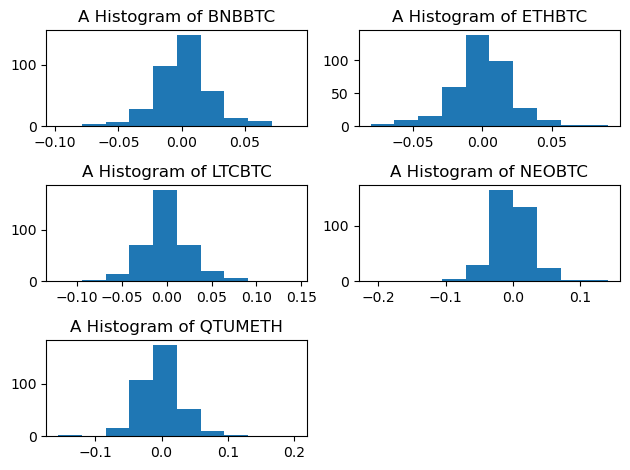

In [37]:
plt.subplot(3,2,1)
plt.hist(rets['BNBBTC'], bins = 10)
plt.title('A Histogram of BNBBTC')
plt.subplot(3,2,2)
plt.hist(rets['ETHBTC'], bins = 10)
plt.title('A Histogram of ETHBTC')
plt.subplot(3,2,3)
plt.hist(rets['LTCBTC'], bins = 10)
plt.title('A Histogram of LTCBTC')
plt.subplot(3,2,4)
plt.hist(rets['NEOBTC'], bins = 10)
plt.title('A Histogram of NEOBTC')
plt.subplot(3,2,5)
plt.hist(rets['QTUMETH'], bins = 10)
plt.title('A Histogram of QTUMETH')
plt.tight_layout()

In MVP, the **average returns** of the financial instruments play an important role since they are used to approximate the **expected returns**.

In [38]:
rets.mean()  # daily mean returns

Asset
BNBBTC     0.001702
ETHBTC     0.000111
LTCBTC    -0.000438
NEOBTC    -0.001554
QTUMETH   -0.001302
dtype: float64

In [40]:
rets.mean() * 366  # annualied mean returns

Asset
BNBBTC     0.622984
ETHBTC     0.040453
LTCBTC    -0.160244
NEOBTC    -0.568806
QTUMETH   -0.476364
dtype: float64

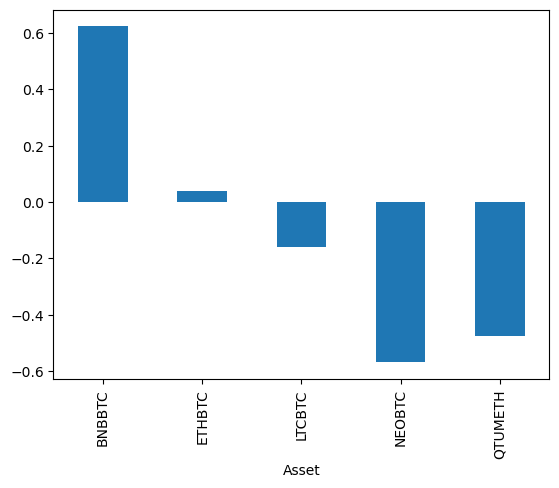

In [49]:
(rets.mean() * 366).plot(kind="bar")
plt.show()

On the other hand, the historical volatility (standard deviation of returns) plays an important role, although it is not used

In [44]:
rets.std()  # daily volatilities

Asset
BNBBTC     0.022337
ETHBTC     0.021900
LTCBTC     0.027267
NEOBTC     0.031551
QTUMETH    0.032497
dtype: float64

In [47]:
rets.std() * math.sqrt(366)  # annualized volatilities

Asset
BNBBTC     0.427327
ETHBTC     0.418980
LTCBTC     0.521653
NEOBTC     0.603601
QTUMETH    0.621713
dtype: float64

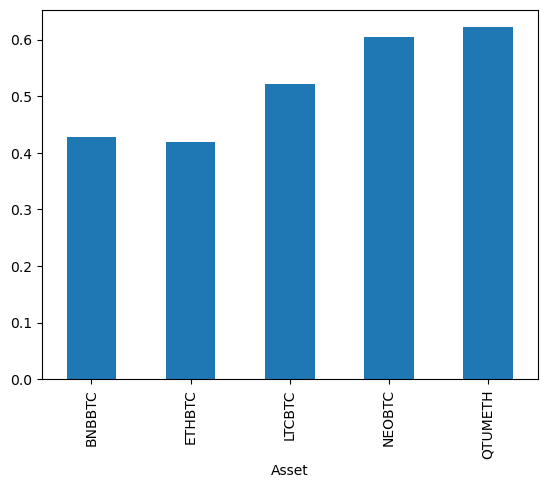

In [101]:
(rets.std() * math.sqrt(366)).plot(kind='bar')
plt.show()

## Portfolio Statistics

Assume a portfolio composed of **all financial instruments** with **equal weighting**.

In [55]:
weights = len(rics) * [1 / len(rics)]
weights

[0.2, 0.2, 0.2, 0.2, 0.2]

The **expected portfolio return** according to MVP is the dot product of the expected returns and the weights.

In [56]:
np.dot(rets.mean() * 366, weights)

-0.10839537887785164

In [59]:
def portfolio_return(symbols, weights):
    return np.dot(rets[symbols].mean() * 366, weights)

In [60]:
portfolio_return(rics, weights)

-0.10839537887785164

`pandas` allows to derive the **covariance matrix** with a single method call. It plays a major role in the theory of Markowitz (1952) in that it accounts for **diversification** effects.

In [61]:
data.cov() * 366  # annualized covariance matrix by column

Asset,BNBBTC,ETHBTC,LTCBTC,NEOBTC,QTUMETH
Asset,,,,,
BNBBTC,0.001090,0.000938,-0.000027,-0.000027,-0.000104
ETHBTC,0.000938,0.020163,0.000572,0.000105,0.000024
LTCBTC,-0.000027,0.000572,0.000059,0.000012,0.000044
NEOBTC,-0.000027,0.000105,0.000012,0.000003,0.000013
QTUMETH,-0.000104,0.000024,0.000044,0.000013,0.000068


With the covariance matrix, **expected portfolio variance** is calculated as follows.

In [62]:
np.dot(weights, np.dot(rets.cov() * 366, weights))

0.11656108091650114

Accordingly, **expected portfolio volatility** is then given by:

In [63]:
math.sqrt(np.dot(weights, np.dot(rets.cov() * 366, weights)))

0.3414104288338321

In [64]:
def portfolio_volatility(symbols, weights):
    return math.sqrt(np.dot(weights, np.dot(rets[symbols].cov() * 366, weights)))

In [65]:
portfolio_volatility(rics, weights)

0.3414104288338321

## Simulating Portfolio Compositions &mdash; Two Instruments

To get started, consider just two financial instruments for which **portfolio compositions** are simulated that add up to 100% (= 1).

In [70]:
fis = ['BNBBTC', 'ETHBTC']

In [71]:
w = np.random.random((500, len(fis)))  # random portfolio compositions ...

In [72]:
w[:5].round(2)  # ... that do not yet add up to 100%

array([[0.76, 0.3 ],
       [0.09, 0.83],
       [0.86, 0.98],
       [0.73, 0.81],
       [0.85, 0.91]])

In [73]:
w = (w.T / w.sum(axis=1)).T  # normalization ...

In [74]:
w[:5].round(2)  # ... let's the random numbers add up to 100%

array([[0.72, 0.28],
       [0.1 , 0.9 ],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.49, 0.51]])

In [75]:
w.sum(axis=1)[:5] # ... let's the random numbers add up to 100%

array([1., 1., 1., 1., 1.])

Given these random composition, the resulting **portfolio statistics** can be derived.

In [76]:
mvp = [(portfolio_volatility(fis, weights),
       portfolio_return(fis, weights))
         for weights in w]

In [77]:
mvp = pd.DataFrame(np.array(mvp), columns=['volatility', 'return'])
mvp.iloc[:5]

,volatility,return
0,0.370592,0.459859
1,0.396313,0.098215
2,0.354101,0.313107
3,0.354055,0.316650
4,0.354029,0.322992


These results can then be **visualized**.

<AxesSubplot:xlabel='volatility', ylabel='return'>

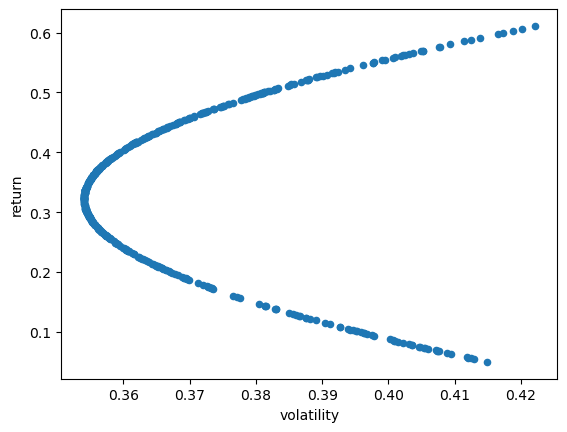

In [81]:
mvp.plot(x='volatility', y='return', kind='scatter')

## Simulating Portfolio Compositions &mdash; All Instruments

Second, consider portfolio compositions for **all financial instruments**. The code is basically the same.

In [82]:
w = np.random.random((2500, len(rics)))  # random portfolio compositions ...

In [83]:
w[:5].round(2)  # ... that do not yet add up to 100%

array([[0.96, 0.55, 0.44, 0.34, 0.1 ],
       [0.56, 0.39, 0.3 , 0.51, 0.69],
       [0.8 , 0.57, 0.89, 0.82, 0.42],
       [0.45, 0.26, 0.64, 0.35, 0.94],
       [0.82, 0.02, 0.26, 0.58, 0.67]])

In [84]:
w = (w.T / w.sum(axis=1)).T  # normalization ...

In [85]:
w[:5].round(2)  # ... let's the random numbers add up to 100%

array([[0.4 , 0.23, 0.18, 0.14, 0.04],
       [0.23, 0.16, 0.12, 0.21, 0.28],
       [0.23, 0.16, 0.25, 0.23, 0.12],
       [0.17, 0.1 , 0.24, 0.13, 0.36],
       [0.35, 0.01, 0.11, 0.24, 0.29]])

In [86]:
w.sum(axis=1)[:5] # ... let's the random numbers add up to 100%

array([1., 1., 1., 1., 1.])

Given these random composition, the resulting **portfolio statistics** can be derived.

In [87]:
mvp = [(portfolio_volatility(rics, weights),
       portfolio_return(rics, weights))
         for weights in w]

In [88]:
mvp = pd.DataFrame(np.array(mvp), columns=['volatility', 'return'])
mvp.iloc[:5]

,volatility,return
0,0.338874,-0.006315
1,0.347718,-0.193513
2,0.341086,-0.049294
3,0.345834,-0.102086
4,0.339299,-0.192443


These results can then be **visualized**.

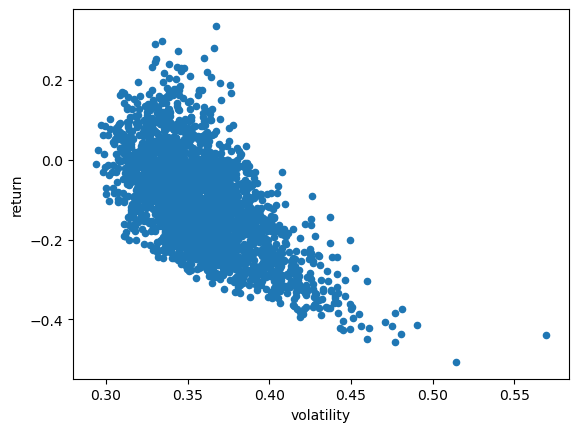

In [91]:
mvp.plot(x='volatility', y='return', kind='scatter')
plt.show()

## Minimum Volatility Portfolio

Let us now derive the portfolio composition that **minimizes the expected volatility** of the portfolio. First, the **boundary conditions** for the single weights (between 0 and 1).

In [92]:
bounds = len(rics) * [(0, 1)]

In [93]:
bounds

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

Second, the condition that the **weights add up to 100%**.

In [94]:
constraints = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1} 

In [96]:
# help(sco.minimize)

Third, the **function to be minimized**. This is the function `portfolio_volatility()` from above.

These three elements are used in combination with the **general minimizer function `sco.minimize()`** to derive the minimum volatility portfolio.

In [97]:
res = sco.minimize(lambda x: portfolio_volatility(rics, x),  # function to be minized
                   len(rics) * [1 / len(rics)],  # initial guess
                   bounds=bounds,  # boundary conditions
                   constraints=constraints  # single equality constraint
                  )

The **results** are:

In [98]:
res

     fun: 0.28891074456482535
     jac: array([0.2889914 , 0.28867698, 0.28891001, 0.37747914, 0.28876863])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([5.23089613e-01, 1.12020770e-03, 1.81715525e-01, 2.86229374e-17,
       2.94074654e-01])

In [99]:
res['fun']  # minimum volatility

0.28891074456482535

In [100]:
for r in zip(rics, res['x']):
    print('%7s | %7.3f' % (r[0], r[1])) # optimal portfolio composition

 ETHBTC |   0.523
 LTCBTC |   0.001
 BNBBTC |   0.182
 NEOBTC |   0.000
QTUMETH |   0.294
